<a href="https://colab.research.google.com/github/Deleon57/EDAR-REGRESSION-FSR-/blob/main/RF(FSR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [15]:
# Load dataset
data2 = pd.read_csv("FSR_JO_data.csv")

# Convert Date column to datetime
data2['Date'] = pd.to_datetime(data2['Date'])
data2 = data2.sort_values('Date')
data2.set_index('Date', inplace=True)

print(data2.head())




                  Close         High          Low         Open
Date                                                          
2012-12-31  3081.709961  3090.656861  3042.940061  3061.827961
2013-01-01  3081.709961  3081.709961  3081.709961  3081.709961
2013-01-02  3108.550781  3126.444582  3084.692381  3101.592081
2013-01-03  3121.474609  3121.474609  3065.804999  3098.610305
2013-01-04  3138.373779  3154.279380  3103.580278  3119.485879


/tmp/ipython-input-1868390719.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data2['Date'] = pd.to_datetime(data2['Date'])


In [16]:
from statsmodels.tsa.stattools import adfuller

# Loop through each feature
for col in ["Close", "High", "Low", "Open"]:
    result = adfuller(data2[col].dropna())
    print(f"Feature: {col}")
    print("  ADF Statistic:", result[0])
    print("  p-value:", result[1])
    print("-" * 40)


Feature: Close
  ADF Statistic: -2.052811843378031
  p-value: 0.263907332041285
----------------------------------------
Feature: High
  ADF Statistic: -1.9909620127346261
  p-value: 0.29054994809258267
----------------------------------------
Feature: Low
  ADF Statistic: -2.1836814379580116
  p-value: 0.21222137226054105
----------------------------------------
Feature: Open
  ADF Statistic: -1.9385434376109192
  p-value: 0.3141518484278628
----------------------------------------


In [21]:
# Define the ADF test function
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'Augmented Dickey-Fuller Test: {title}')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('-'*50)

features = data2.select_dtypes(include=[np.number]).columns

# Calculate percentage change (returns)
data_returns = data2[features].pct_change().dropna()

# Run ADF test on each feature
for col in features:
    adf_test(data_returns[col], title=f"{col} (Returns)")

Augmented Dickey-Fuller Test: Close (Returns)
ADF Statistic: -29.909176506431187
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: High (Returns)
ADF Statistic: -30.1866786326477
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: Low (Returns)
ADF Statistic: -28.99375505905364
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: Open (Returns)
ADF Statistic: -22.409828887620833
p-value: 0.0
--------------------------------------------------


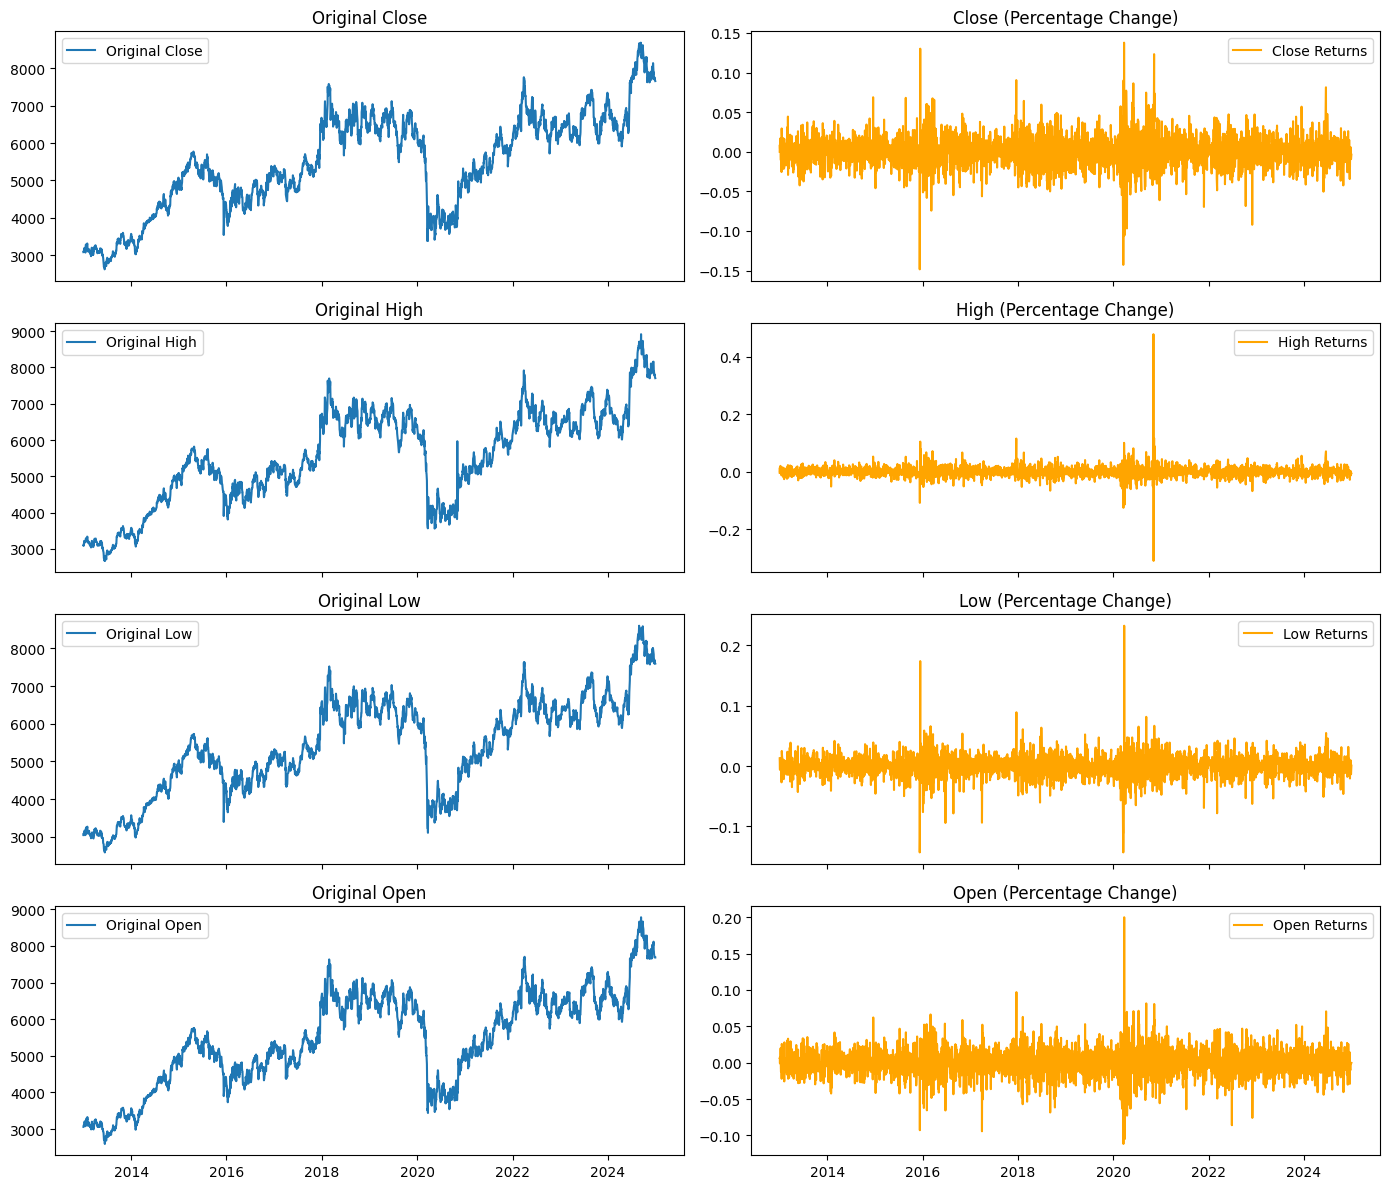

In [22]:
n_features = len(features)
fig, axes = plt.subplots(n_features, 2, figsize=(14, 3*n_features), sharex=True)

for i, col in enumerate(features):

    axes[i,0].plot(data2[col], label=f"Original {col}")
    axes[i,0].set_title(f"Original {col}")
    axes[i,0].legend()

    axes[i,1].plot(data_returns[col], label=f"{col} Returns", color='orange')
    axes[i,1].set_title(f"{col} (Percentage Change)")
    axes[i,1].legend()

plt.tight_layout()
plt.show()

In [23]:
from sklearn.preprocessing import StandardScaler

train = data_returns[data_returns.index < "2023-01-01"]
test  = data_returns[data_returns.index >= "2023-01-01"]

# Features (X) and Target (y)
X_train = train[["High", "Low", "Open"]]
y_train = train["Close"]

X_test = test[["High", "Low", "Open"]]
y_test = test["Close"]

print("Before scaling:")
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nAfter scaling:")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

Before scaling:
Train shape: (2551, 3) (2551,)
Test shape: (497, 3) (497,)

After scaling:
X_train_scaled shape: (2551, 3)
X_test_scaled shape: (497, 3)


In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Fit Random Forest model ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# --- Predictions ---
y_pred = rf.predict(X_test)

# --- Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
smape = (100/len(y_test)) * np.sum(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))
r2 = r2_score(y_test, y_pred)

# --- Put results in DataFrame like your first screenshot ---
results_df = pd.DataFrame({
    "Model": ["RandomForest"],
    "RMSE": [rmse],
    "MAE": [mae],
    "MAPE%": [mape],
    "SMAPE%": [smape],
    "R²": [r2]
})

display(results_df)


,Model,RMSE,MAE,MAPE%,SMAPE%,R²
0,RandomForest,0.008841,0.006929,inf,97.077924,0.664043


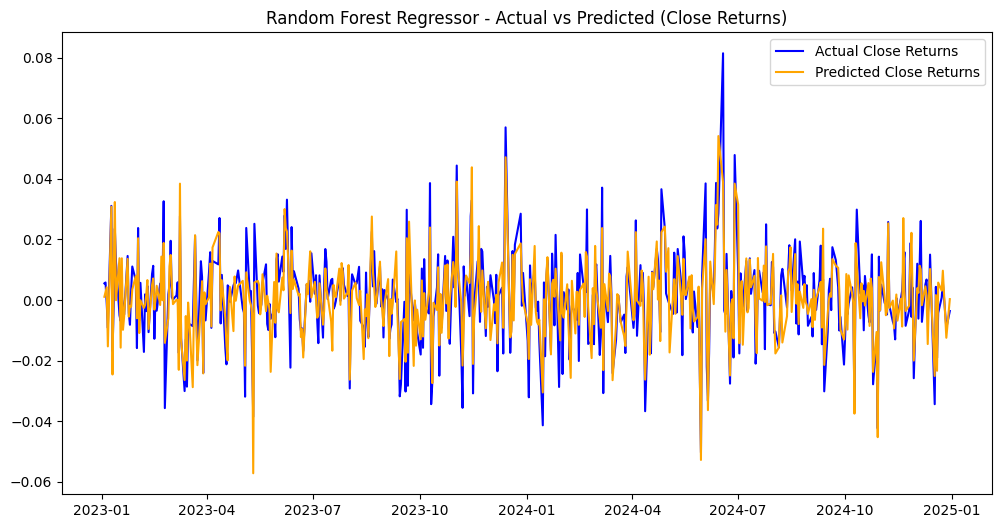

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual Close Returns", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted Close Returns", color="orange")
plt.title("Random Forest Regressor - Actual vs Predicted (Close Returns)")
plt.legend()
plt.show()


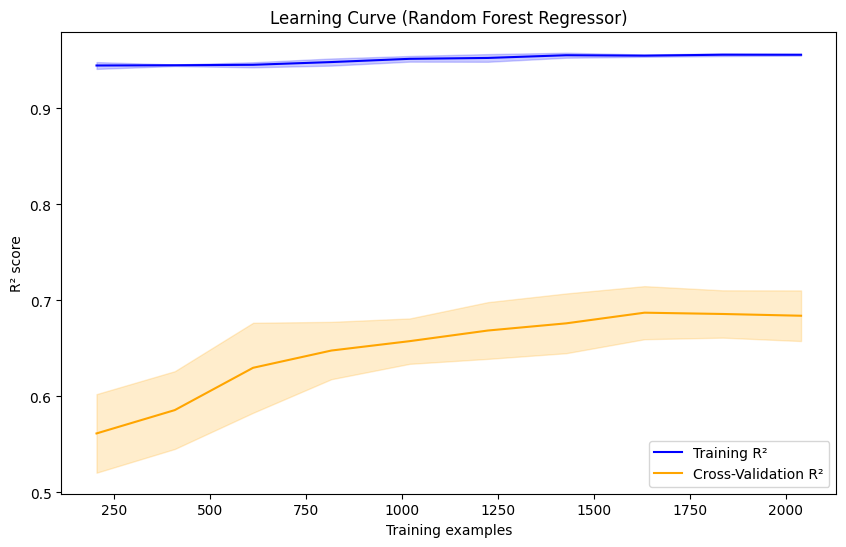

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_model,
    X=X_train,
    y=y_train,
    cv=5,                     # 5-fold cross validation
    scoring="r2",             # use R² score
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training R²", color="blue")
plt.plot(train_sizes, test_mean, label="Cross-Validation R²", color="orange")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="orange")

plt.title("Learning Curve (Random Forest Regressor)")
plt.xlabel("Training examples")
plt.ylabel("R² score")
plt.legend(loc="best")
plt.show()


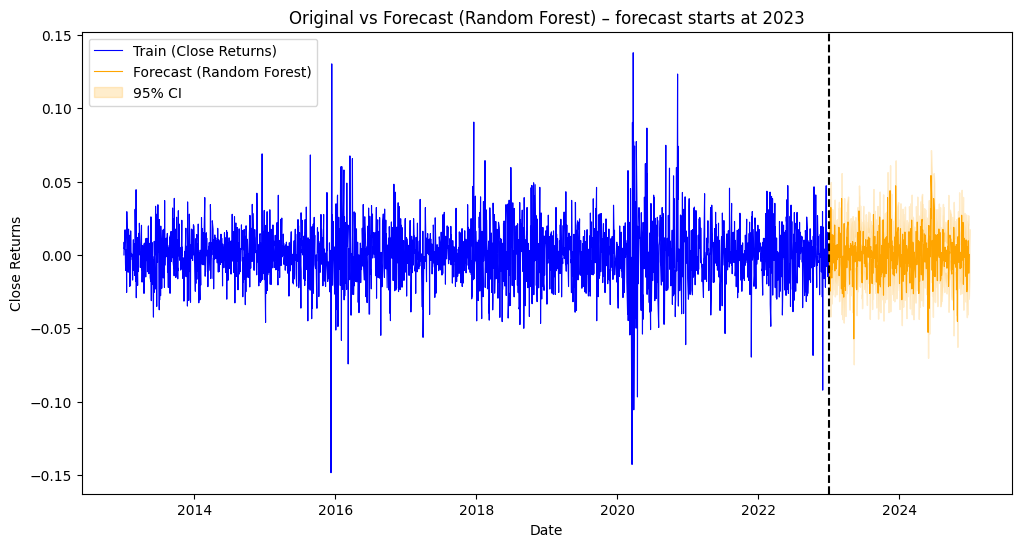

In [27]:
error = y_test.values - y_pred
err_std = np.std(error)
lower = y_pred - 1.96 * err_std
upper = y_pred + 1.96 * err_std

plt.figure(figsize=(12,6))

# Training data (blue) – use actual index
plt.plot(y_train.index, y_train.values, label="Train (Close Returns)", color="blue", linewidth=0.8)

# Forecast (orange) – align with test index
plt.plot(y_test.index, y_pred, label="Forecast (Random Forest)", color="orange", linewidth=0.8)

plt.fill_between(y_test.index, lower, upper, color="orange", alpha=0.2, label="95% CI")

plt.axvline(x=y_test.index[0], color="k", linestyle="--")

plt.title("Original vs Forecast (Random Forest) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()


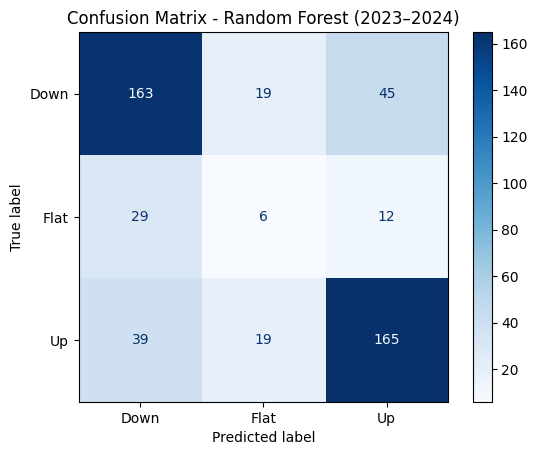

Classification Report - Random Forest
              precision    recall  f1-score   support

        Down       0.71      0.72      0.71       227
        Flat       0.14      0.13      0.13        47
          Up       0.74      0.74      0.74       223

    accuracy                           0.67       497
   macro avg       0.53      0.53      0.53       497
weighted avg       0.67      0.67      0.67       497



In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred).flatten()

def to_class(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = Up, -1 = Down, 0 = Flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1          # Up
    cls[delta < -eps] = -1        # Down
    return cls

delta_true = np.diff(y_test_arr, prepend=y_test_arr[0])
delta_pred = np.diff(y_pred_arr, prepend=y_pred_arr[0])

true_cls = to_class(delta_true)
pred_cls = to_class(delta_pred)

labels = [-1, 0, 1]  # Down, Flat, Up
cm = confusion_matrix(true_cls, pred_cls, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Flat", "Up"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest (2023–2024)")
plt.show()

print("Classification Report - Random Forest")
print(classification_report(true_cls, pred_cls, target_names=["Down", "Flat", "Up"]))


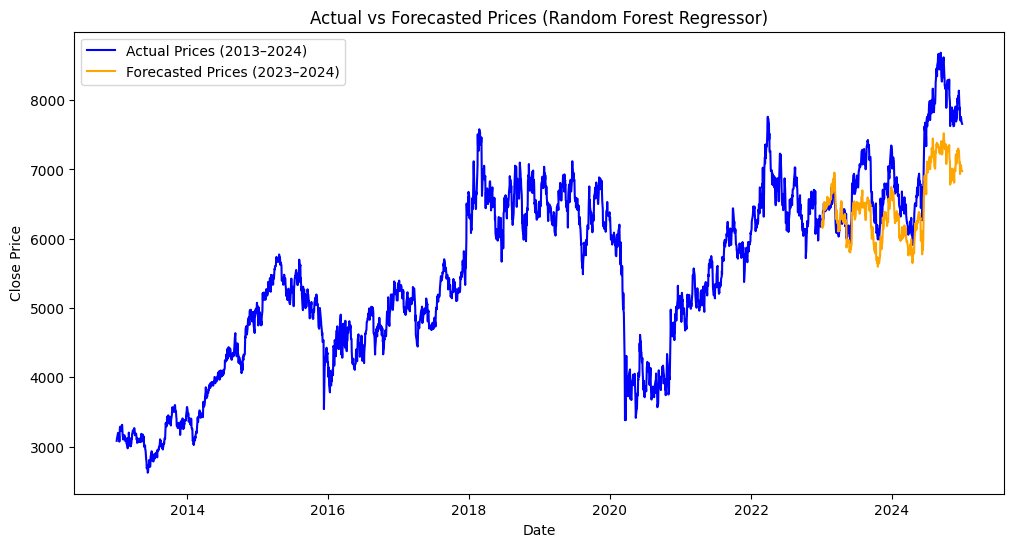

In [31]:
P0 = data2["Close"].iloc[0]

# Rebuild prices from returns
reconstructed_prices = (1 + data_returns["Close"]).cumprod() * P0

last_price_2022 = data2.loc[data2.index < "2023-01-01", "Close"].iloc[-1]

# Convert forecasted returns (y_pred) into price levels
forecast_prices = (1 + pd.Series(y_pred, index=y_test.index)).cumprod() * last_price_2022

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(reconstructed_prices.index, reconstructed_prices, label="Actual Prices (2013–2024)", color="blue")

plt.plot(forecast_prices.index, forecast_prices, label="Forecasted Prices (2023–2024)", color="orange")

plt.title("Actual vs Forecasted Prices (Random Forest Regressor)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


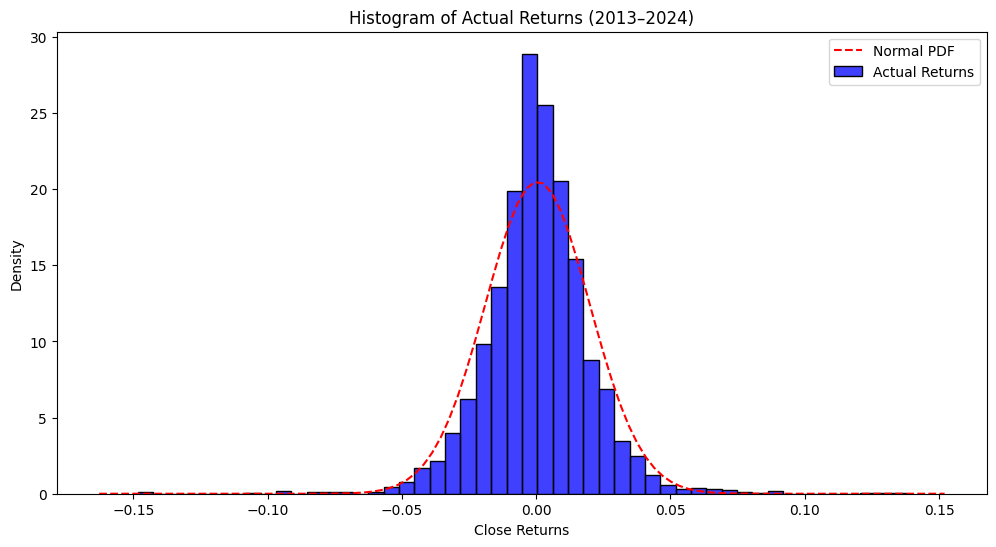

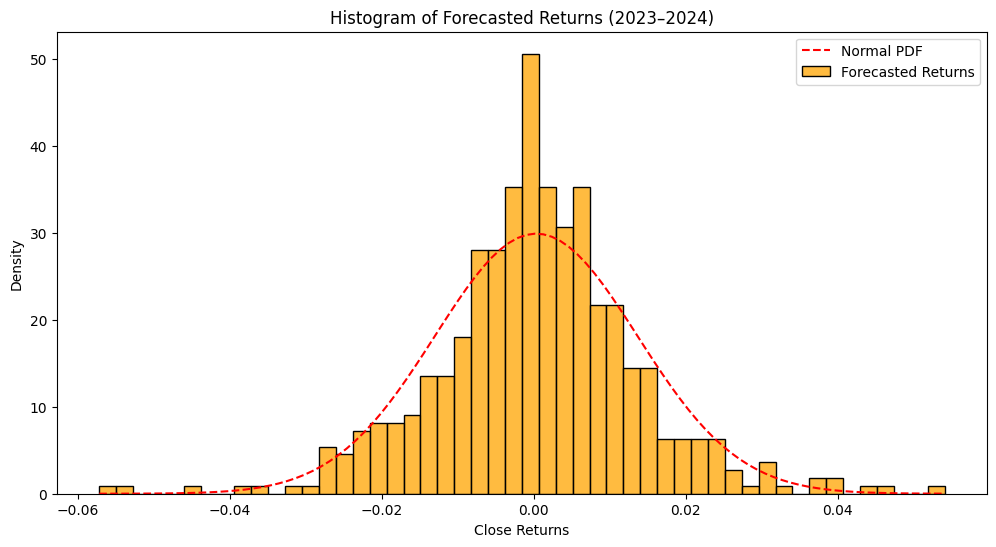

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

plt.figure(figsize=(12,6))
sns.histplot(data_returns["Close"], bins=50, kde=False, color="blue", stat="density", label="Actual Returns")

mu, std = stats.norm.fit(data_returns["Close"].dropna())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r--", label="Normal PDF")

plt.title("Histogram of Actual Returns (2013–2024)")
plt.xlabel("Close Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(y_pred, bins=50, kde=False, color="orange", stat="density", label="Forecasted Returns")

mu, std = stats.norm.fit(y_pred)
x = np.linspace(min(y_pred), max(y_pred), 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r--", label="Normal PDF")

plt.title("Histogram of Forecasted Returns (2023–2024)")
plt.xlabel("Close Returns")
plt.ylabel("Density")
plt.legend()
plt.show()
